# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.SELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.SELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.SELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.SELU(),
            nn.Linear(hidden5_size, output_size)
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 32, 64, 128, 64, 32, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): SELU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): SELU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SELU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): SELU()
    (10): Linear(in_features=32, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 32, 64, 128, 64, 32, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
#optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/800, Iteration 1/12, Loss: 1.2765
Epoch 1/800, Iteration 2/12, Loss: 0.7467
Epoch 1/800, Iteration 3/12, Loss: 3.1496
Epoch 1/800, Iteration 4/12, Loss: 0.7091
Epoch 1/800, Iteration 5/12, Loss: 0.6507
Epoch 1/800, Iteration 6/12, Loss: 0.5261
Epoch 1/800, Iteration 7/12, Loss: 0.4171
Epoch 1/800, Iteration 8/12, Loss: 0.3727
Epoch 1/800, Iteration 9/12, Loss: 0.2011
Epoch 1/800, Iteration 10/12, Loss: 0.3385
Epoch 1/800, Iteration 11/12, Loss: 0.2487
Epoch 1/800, Iteration 12/12, Loss: 0.1943
Epoch 1/800, Iteration 13/12, Loss: 0.1758
Train Error: 
 Accuracy: 50.5%, Avg loss: 0.168861, MRE: 0.256842, MAE: 0.047492 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.152605, MRE: 0.222117, MAE: 0.047025 

Epoch 2/800, Iteration 1/12, Loss: 0.1929
Epoch 2/800, Iteration 2/12, Loss: 0.1436
Epoch 2/800, Iteration 3/12, Loss: 0.1134
Epoch 2/800, Iteration 4/12, Loss: 0.1747
Epoch 2/800, Iteration 5/12, Loss: 0.1476
Epoch 2/800, Iteration 6/12, Loss: 0.1866
Epoch 2/800, Iteration 7/12, Loss

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.007745, MRE: 0.041311, MAE: 0.008728 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.008969, MRE: 0.042625, MAE: 0.009209 

Epoch 13/800, Iteration 1/12, Loss: 0.0084
Epoch 13/800, Iteration 2/12, Loss: 0.0031
Epoch 13/800, Iteration 3/12, Loss: 0.0090
Epoch 13/800, Iteration 4/12, Loss: 0.0070
Epoch 13/800, Iteration 5/12, Loss: 0.0068
Epoch 13/800, Iteration 6/12, Loss: 0.0038
Epoch 13/800, Iteration 7/12, Loss: 0.0047
Epoch 13/800, Iteration 8/12, Loss: 0.0144
Epoch 13/800, Iteration 9/12, Loss: 0.0127
Epoch 13/800, Iteration 10/12, Loss: 0.0081
Epoch 13/800, Iteration 11/12, Loss: 0.0111
Epoch 13/800, Iteration 12/12, Loss: 0.0041
Epoch 13/800, Iteration 13/12, Loss: 0.0125
Train Error: 
 Accuracy: 76.12%, Avg loss: 0.013039, MRE: 0.053781, MAE: 0.011588 

Test Error: 
 Accuracy: 80.5%, Avg loss: 0.011847, MRE: 0.051580, MAE: 0.011731 

Epoch 14/800, Iteration 1/12, Loss: 0.0128
Epoch 14/800, Iteration 2/12, Loss: 0.0130
Epoch 14/800, Itera

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.004221, MRE: 0.036590, MAE: 0.006447 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.003593, MRE: 0.031910, MAE: 0.005675 

Epoch 25/800, Iteration 1/12, Loss: 0.0036
Epoch 25/800, Iteration 2/12, Loss: 0.0043
Epoch 25/800, Iteration 3/12, Loss: 0.0047
Epoch 25/800, Iteration 4/12, Loss: 0.0034
Epoch 25/800, Iteration 5/12, Loss: 0.0055
Epoch 25/800, Iteration 6/12, Loss: 0.0070
Epoch 25/800, Iteration 7/12, Loss: 0.0064
Epoch 25/800, Iteration 8/12, Loss: 0.0102
Epoch 25/800, Iteration 9/12, Loss: 0.0121
Epoch 25/800, Iteration 10/12, Loss: 0.0096
Epoch 25/800, Iteration 11/12, Loss: 0.0039
Epoch 25/800, Iteration 12/12, Loss: 0.0110
Epoch 25/800, Iteration 13/12, Loss: 0.0067
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.004994, MRE: 0.042283, MAE: 0.007500 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.004771, MRE: 0.036735, MAE: 0.007142 

Epoch 26/800, Iteration 1/12, Loss: 0.0067
Epoch 26/800, Iteration 2/12, Loss: 0.0061
Epoch 26/800, Iterati

Train Error: 
 Accuracy: 43.62%, Avg loss: 0.026349, MRE: 0.086170, MAE: 0.015718 

Test Error: 
 Accuracy: 40.0%, Avg loss: 0.026201, MRE: 0.082807, MAE: 0.015165 

Epoch 37/800, Iteration 1/12, Loss: 0.0286
Epoch 37/800, Iteration 2/12, Loss: 0.0418
Epoch 37/800, Iteration 3/12, Loss: 0.0264
Epoch 37/800, Iteration 4/12, Loss: 0.0226
Epoch 37/800, Iteration 5/12, Loss: 0.0275
Epoch 37/800, Iteration 6/12, Loss: 0.0470
Epoch 37/800, Iteration 7/12, Loss: 0.0252
Epoch 37/800, Iteration 8/12, Loss: 0.0418
Epoch 37/800, Iteration 9/12, Loss: 0.0388
Epoch 37/800, Iteration 10/12, Loss: 0.0302
Epoch 37/800, Iteration 11/12, Loss: 0.0346
Epoch 37/800, Iteration 12/12, Loss: 0.0312
Epoch 37/800, Iteration 13/12, Loss: 0.0392
Train Error: 
 Accuracy: 76.0%, Avg loss: 0.041331, MRE: 0.140803, MAE: 0.023051 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.039285, MRE: 0.116489, MAE: 0.021969 

Epoch 38/800, Iteration 1/12, Loss: 0.0412
Epoch 38/800, Iteration 2/12, Loss: 0.0291
Epoch 38/800, Iterat

Train Error: 
 Accuracy: 99.5%, Avg loss: 0.000979, MRE: 0.019168, MAE: 0.003080 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000806, MRE: 0.014867, MAE: 0.002820 

Epoch 49/800, Iteration 1/12, Loss: 0.0011
Epoch 49/800, Iteration 2/12, Loss: 0.0012
Epoch 49/800, Iteration 3/12, Loss: 0.0009
Epoch 49/800, Iteration 4/12, Loss: 0.0009
Epoch 49/800, Iteration 5/12, Loss: 0.0008
Epoch 49/800, Iteration 6/12, Loss: 0.0007
Epoch 49/800, Iteration 7/12, Loss: 0.0010
Epoch 49/800, Iteration 8/12, Loss: 0.0014
Epoch 49/800, Iteration 9/12, Loss: 0.0011
Epoch 49/800, Iteration 10/12, Loss: 0.0012
Epoch 49/800, Iteration 11/12, Loss: 0.0008
Epoch 49/800, Iteration 12/12, Loss: 0.0008
Epoch 49/800, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.000972, MRE: 0.019064, MAE: 0.003059 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000806, MRE: 0.014764, MAE: 0.002936 

Epoch 50/800, Iteration 1/12, Loss: 0.0006
Epoch 50/800, Iteration 2/12, Loss: 0.0009
Epoch 50/800, Iterat

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000634, MRE: 0.016322, MAE: 0.002518 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000643, MRE: 0.013785, MAE: 0.002544 

Epoch 61/800, Iteration 1/12, Loss: 0.0007
Epoch 61/800, Iteration 2/12, Loss: 0.0006
Epoch 61/800, Iteration 3/12, Loss: 0.0007
Epoch 61/800, Iteration 4/12, Loss: 0.0007
Epoch 61/800, Iteration 5/12, Loss: 0.0006
Epoch 61/800, Iteration 6/12, Loss: 0.0004
Epoch 61/800, Iteration 7/12, Loss: 0.0005
Epoch 61/800, Iteration 8/12, Loss: 0.0006
Epoch 61/800, Iteration 9/12, Loss: 0.0008
Epoch 61/800, Iteration 10/12, Loss: 0.0004
Epoch 61/800, Iteration 11/12, Loss: 0.0006
Epoch 61/800, Iteration 12/12, Loss: 0.0005
Epoch 61/800, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000562, MRE: 0.015683, MAE: 0.002414 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000548, MRE: 0.012672, MAE: 0.002403 

Epoch 62/800, Iteration 1/12, Loss: 0.0004
Epoch 62/800, Iteration 2/12, Loss: 0.0006
Epoch 62/800, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.000506, MRE: 0.014531, MAE: 0.002350 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000531, MRE: 0.012569, MAE: 0.002416 

Epoch 73/800, Iteration 1/12, Loss: 0.0004
Epoch 73/800, Iteration 2/12, Loss: 0.0006
Epoch 73/800, Iteration 3/12, Loss: 0.0004
Epoch 73/800, Iteration 4/12, Loss: 0.0005
Epoch 73/800, Iteration 5/12, Loss: 0.0005
Epoch 73/800, Iteration 6/12, Loss: 0.0005
Epoch 73/800, Iteration 7/12, Loss: 0.0005
Epoch 73/800, Iteration 8/12, Loss: 0.0006
Epoch 73/800, Iteration 9/12, Loss: 0.0005
Epoch 73/800, Iteration 10/12, Loss: 0.0004
Epoch 73/800, Iteration 11/12, Loss: 0.0004
Epoch 73/800, Iteration 12/12, Loss: 0.0006
Epoch 73/800, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000505, MRE: 0.015560, MAE: 0.002319 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000521, MRE: 0.013001, MAE: 0.002367 

Epoch 74/800, Iteration 1/12, Loss: 0.0005
Epoch 74/800, Iteration 2/12, Loss: 0.0005
Epoch 74/800, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000381, MRE: 0.012963, MAE: 0.002038 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000444, MRE: 0.011583, MAE: 0.002195 

Epoch 85/800, Iteration 1/12, Loss: 0.0003
Epoch 85/800, Iteration 2/12, Loss: 0.0004
Epoch 85/800, Iteration 3/12, Loss: 0.0004
Epoch 85/800, Iteration 4/12, Loss: 0.0003
Epoch 85/800, Iteration 5/12, Loss: 0.0004
Epoch 85/800, Iteration 6/12, Loss: 0.0005
Epoch 85/800, Iteration 7/12, Loss: 0.0004
Epoch 85/800, Iteration 8/12, Loss: 0.0003
Epoch 85/800, Iteration 9/12, Loss: 0.0004
Epoch 85/800, Iteration 10/12, Loss: 0.0007
Epoch 85/800, Iteration 11/12, Loss: 0.0005
Epoch 85/800, Iteration 12/12, Loss: 0.0003
Epoch 85/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000371, MRE: 0.013364, MAE: 0.001995 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000400, MRE: 0.010995, MAE: 0.002037 

Epoch 86/800, Iteration 1/12, Loss: 0.0004
Epoch 86/800, Iteration 2/12, Loss: 0.0003
Epoch 86/800, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000395, MRE: 0.012941, MAE: 0.002041 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000495, MRE: 0.011682, MAE: 0.002297 

Epoch 97/800, Iteration 1/12, Loss: 0.0004
Epoch 97/800, Iteration 2/12, Loss: 0.0004
Epoch 97/800, Iteration 3/12, Loss: 0.0005
Epoch 97/800, Iteration 4/12, Loss: 0.0003
Epoch 97/800, Iteration 5/12, Loss: 0.0004
Epoch 97/800, Iteration 6/12, Loss: 0.0003
Epoch 97/800, Iteration 7/12, Loss: 0.0004
Epoch 97/800, Iteration 8/12, Loss: 0.0004
Epoch 97/800, Iteration 9/12, Loss: 0.0003
Epoch 97/800, Iteration 10/12, Loss: 0.0004
Epoch 97/800, Iteration 11/12, Loss: 0.0005
Epoch 97/800, Iteration 12/12, Loss: 0.0006
Epoch 97/800, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000325, MRE: 0.012194, MAE: 0.001845 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000393, MRE: 0.010805, MAE: 0.002087 

Epoch 98/800, Iteration 1/12, Loss: 0.0003
Epoch 98/800, Iteration 2/12, Loss: 0.0004
Epoch 98/800, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000284, MRE: 0.011071, MAE: 0.001736 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000380, MRE: 0.010202, MAE: 0.001976 

Epoch 109/800, Iteration 1/12, Loss: 0.0004
Epoch 109/800, Iteration 2/12, Loss: 0.0003
Epoch 109/800, Iteration 3/12, Loss: 0.0003
Epoch 109/800, Iteration 4/12, Loss: 0.0003
Epoch 109/800, Iteration 5/12, Loss: 0.0003
Epoch 109/800, Iteration 6/12, Loss: 0.0003
Epoch 109/800, Iteration 7/12, Loss: 0.0003
Epoch 109/800, Iteration 8/12, Loss: 0.0003
Epoch 109/800, Iteration 9/12, Loss: 0.0003
Epoch 109/800, Iteration 10/12, Loss: 0.0003
Epoch 109/800, Iteration 11/12, Loss: 0.0003
Epoch 109/800, Iteration 12/12, Loss: 0.0003
Epoch 109/800, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000265, MRE: 0.011482, MAE: 0.001681 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000352, MRE: 0.010284, MAE: 0.001934 

Epoch 110/800, Iteration 1/12, Loss: 0.0002
Epoch 110/800, Iteration 2/12, Loss: 0.0003
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000273, MRE: 0.010865, MAE: 0.001700 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000359, MRE: 0.009711, MAE: 0.001848 

Epoch 121/800, Iteration 1/12, Loss: 0.0003
Epoch 121/800, Iteration 2/12, Loss: 0.0003
Epoch 121/800, Iteration 3/12, Loss: 0.0003
Epoch 121/800, Iteration 4/12, Loss: 0.0002
Epoch 121/800, Iteration 5/12, Loss: 0.0002
Epoch 121/800, Iteration 6/12, Loss: 0.0003
Epoch 121/800, Iteration 7/12, Loss: 0.0003
Epoch 121/800, Iteration 8/12, Loss: 0.0002
Epoch 121/800, Iteration 9/12, Loss: 0.0002
Epoch 121/800, Iteration 10/12, Loss: 0.0003
Epoch 121/800, Iteration 11/12, Loss: 0.0003
Epoch 121/800, Iteration 12/12, Loss: 0.0002
Epoch 121/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000253, MRE: 0.011323, MAE: 0.001641 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000340, MRE: 0.009866, MAE: 0.001859 

Epoch 122/800, Iteration 1/12, Loss: 0.0003
Epoch 122/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000231, MRE: 0.010055, MAE: 0.001579 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000344, MRE: 0.009686, MAE: 0.001874 

Epoch 133/800, Iteration 1/12, Loss: 0.0003
Epoch 133/800, Iteration 2/12, Loss: 0.0004
Epoch 133/800, Iteration 3/12, Loss: 0.0002
Epoch 133/800, Iteration 4/12, Loss: 0.0002
Epoch 133/800, Iteration 5/12, Loss: 0.0002
Epoch 133/800, Iteration 6/12, Loss: 0.0009
Epoch 133/800, Iteration 7/12, Loss: 0.0002
Epoch 133/800, Iteration 8/12, Loss: 0.0003
Epoch 133/800, Iteration 9/12, Loss: 0.0003
Epoch 133/800, Iteration 10/12, Loss: 0.0005
Epoch 133/800, Iteration 11/12, Loss: 0.0005
Epoch 133/800, Iteration 12/12, Loss: 0.0005
Epoch 133/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000531, MRE: 0.014208, MAE: 0.002418 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000520, MRE: 0.011742, MAE: 0.002447 

Epoch 134/800, Iteration 1/12, Loss: 0.0005
Epoch 134/800, Iteration 2/12, Loss: 0.0004
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000207, MRE: 0.010273, MAE: 0.001458 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000295, MRE: 0.009030, MAE: 0.001648 

Epoch 145/800, Iteration 1/12, Loss: 0.0002
Epoch 145/800, Iteration 2/12, Loss: 0.0002
Epoch 145/800, Iteration 3/12, Loss: 0.0002
Epoch 145/800, Iteration 4/12, Loss: 0.0002
Epoch 145/800, Iteration 5/12, Loss: 0.0002
Epoch 145/800, Iteration 6/12, Loss: 0.0002
Epoch 145/800, Iteration 7/12, Loss: 0.0003
Epoch 145/800, Iteration 8/12, Loss: 0.0003
Epoch 145/800, Iteration 9/12, Loss: 0.0002
Epoch 145/800, Iteration 10/12, Loss: 0.0002
Epoch 145/800, Iteration 11/12, Loss: 0.0002
Epoch 145/800, Iteration 12/12, Loss: 0.0003
Epoch 145/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000238, MRE: 0.010614, MAE: 0.001666 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000343, MRE: 0.009919, MAE: 0.001829 

Epoch 146/800, Iteration 1/12, Loss: 0.0003
Epoch 146/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000327, MRE: 0.010659, MAE: 0.001661 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000348, MRE: 0.009290, MAE: 0.001816 

Epoch 157/800, Iteration 1/12, Loss: 0.0004
Epoch 157/800, Iteration 2/12, Loss: 0.0002
Epoch 157/800, Iteration 3/12, Loss: 0.0003
Epoch 157/800, Iteration 4/12, Loss: 0.0002
Epoch 157/800, Iteration 5/12, Loss: 0.0002
Epoch 157/800, Iteration 6/12, Loss: 0.0003
Epoch 157/800, Iteration 7/12, Loss: 0.0002
Epoch 157/800, Iteration 8/12, Loss: 0.0002
Epoch 157/800, Iteration 9/12, Loss: 0.0002
Epoch 157/800, Iteration 10/12, Loss: 0.0002
Epoch 157/800, Iteration 11/12, Loss: 0.0002
Epoch 157/800, Iteration 12/12, Loss: 0.0002
Epoch 157/800, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000207, MRE: 0.009266, MAE: 0.001468 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000321, MRE: 0.009008, MAE: 0.001772 

Epoch 158/800, Iteration 1/12, Loss: 0.0002
Epoch 158/800, Iteration 2/12, Loss: 0.0003
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000169, MRE: 0.008905, MAE: 0.001374 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000281, MRE: 0.008337, MAE: 0.001594 

Epoch 169/800, Iteration 1/12, Loss: 0.0002
Epoch 169/800, Iteration 2/12, Loss: 0.0002
Epoch 169/800, Iteration 3/12, Loss: 0.0002
Epoch 169/800, Iteration 4/12, Loss: 0.0002
Epoch 169/800, Iteration 5/12, Loss: 0.0001
Epoch 169/800, Iteration 6/12, Loss: 0.0002
Epoch 169/800, Iteration 7/12, Loss: 0.0002
Epoch 169/800, Iteration 8/12, Loss: 0.0002
Epoch 169/800, Iteration 9/12, Loss: 0.0002
Epoch 169/800, Iteration 10/12, Loss: 0.0002
Epoch 169/800, Iteration 11/12, Loss: 0.0002
Epoch 169/800, Iteration 12/12, Loss: 0.0002
Epoch 169/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000174, MRE: 0.009349, MAE: 0.001369 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000291, MRE: 0.008496, MAE: 0.001721 

Epoch 170/800, Iteration 1/12, Loss: 0.0001
Epoch 170/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000192, MRE: 0.009048, MAE: 0.001378 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000291, MRE: 0.008032, MAE: 0.001589 

Epoch 181/800, Iteration 1/12, Loss: 0.0002
Epoch 181/800, Iteration 2/12, Loss: 0.0002
Epoch 181/800, Iteration 3/12, Loss: 0.0001
Epoch 181/800, Iteration 4/12, Loss: 0.0002
Epoch 181/800, Iteration 5/12, Loss: 0.0002
Epoch 181/800, Iteration 6/12, Loss: 0.0002
Epoch 181/800, Iteration 7/12, Loss: 0.0002
Epoch 181/800, Iteration 8/12, Loss: 0.0002
Epoch 181/800, Iteration 9/12, Loss: 0.0001
Epoch 181/800, Iteration 10/12, Loss: 0.0001
Epoch 181/800, Iteration 11/12, Loss: 0.0002
Epoch 181/800, Iteration 12/12, Loss: 0.0001
Epoch 181/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.008216, MAE: 0.001243 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000278, MRE: 0.008274, MAE: 0.001585 

Epoch 182/800, Iteration 1/12, Loss: 0.0001
Epoch 182/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000150, MRE: 0.008255, MAE: 0.001312 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000260, MRE: 0.007620, MAE: 0.001549 

Epoch 193/800, Iteration 1/12, Loss: 0.0001
Epoch 193/800, Iteration 2/12, Loss: 0.0002
Epoch 193/800, Iteration 3/12, Loss: 0.0001
Epoch 193/800, Iteration 4/12, Loss: 0.0002
Epoch 193/800, Iteration 5/12, Loss: 0.0001
Epoch 193/800, Iteration 6/12, Loss: 0.0002
Epoch 193/800, Iteration 7/12, Loss: 0.0002
Epoch 193/800, Iteration 8/12, Loss: 0.0002
Epoch 193/800, Iteration 9/12, Loss: 0.0003
Epoch 193/800, Iteration 10/12, Loss: 0.0002
Epoch 193/800, Iteration 11/12, Loss: 0.0002
Epoch 193/800, Iteration 12/12, Loss: 0.0002
Epoch 193/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000156, MRE: 0.008199, MAE: 0.001289 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000295, MRE: 0.008515, MAE: 0.001656 

Epoch 194/800, Iteration 1/12, Loss: 0.0001
Epoch 194/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000115, MRE: 0.007470, MAE: 0.001125 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000245, MRE: 0.007472, MAE: 0.001482 

Epoch 205/800, Iteration 1/12, Loss: 0.0001
Epoch 205/800, Iteration 2/12, Loss: 0.0001
Epoch 205/800, Iteration 3/12, Loss: 0.0002
Epoch 205/800, Iteration 4/12, Loss: 0.0001
Epoch 205/800, Iteration 5/12, Loss: 0.0001
Epoch 205/800, Iteration 6/12, Loss: 0.0001
Epoch 205/800, Iteration 7/12, Loss: 0.0001
Epoch 205/800, Iteration 8/12, Loss: 0.0001
Epoch 205/800, Iteration 9/12, Loss: 0.0001
Epoch 205/800, Iteration 10/12, Loss: 0.0001
Epoch 205/800, Iteration 11/12, Loss: 0.0001
Epoch 205/800, Iteration 12/12, Loss: 0.0001
Epoch 205/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000115, MRE: 0.007552, MAE: 0.001127 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000249, MRE: 0.007570, MAE: 0.001501 

Epoch 206/800, Iteration 1/12, Loss: 0.0001
Epoch 206/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000116, MRE: 0.007580, MAE: 0.001131 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000245, MRE: 0.007519, MAE: 0.001491 

Epoch 217/800, Iteration 1/12, Loss: 0.0001
Epoch 217/800, Iteration 2/12, Loss: 0.0001
Epoch 217/800, Iteration 3/12, Loss: 0.0002
Epoch 217/800, Iteration 4/12, Loss: 0.0001
Epoch 217/800, Iteration 5/12, Loss: 0.0001
Epoch 217/800, Iteration 6/12, Loss: 0.0001
Epoch 217/800, Iteration 7/12, Loss: 0.0001
Epoch 217/800, Iteration 8/12, Loss: 0.0001
Epoch 217/800, Iteration 9/12, Loss: 0.0001
Epoch 217/800, Iteration 10/12, Loss: 0.0001
Epoch 217/800, Iteration 11/12, Loss: 0.0002
Epoch 217/800, Iteration 12/12, Loss: 0.0001
Epoch 217/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000114, MRE: 0.007475, MAE: 0.001115 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000252, MRE: 0.007575, MAE: 0.001496 

Epoch 218/800, Iteration 1/12, Loss: 0.0001
Epoch 218/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000116, MRE: 0.009147, MAE: 0.001126 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000248, MRE: 0.007556, MAE: 0.001497 

Epoch 229/800, Iteration 1/12, Loss: 0.0001
Epoch 229/800, Iteration 2/12, Loss: 0.0001
Epoch 229/800, Iteration 3/12, Loss: 0.0001
Epoch 229/800, Iteration 4/12, Loss: 0.0001
Epoch 229/800, Iteration 5/12, Loss: 0.0001
Epoch 229/800, Iteration 6/12, Loss: 0.0001
Epoch 229/800, Iteration 7/12, Loss: 0.0001
Epoch 229/800, Iteration 8/12, Loss: 0.0001
Epoch 229/800, Iteration 9/12, Loss: 0.0001
Epoch 229/800, Iteration 10/12, Loss: 0.0001
Epoch 229/800, Iteration 11/12, Loss: 0.0001
Epoch 229/800, Iteration 12/12, Loss: 0.0001
Epoch 229/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000119, MRE: 0.007581, MAE: 0.001131 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000254, MRE: 0.007580, MAE: 0.001510 

Epoch 230/800, Iteration 1/12, Loss: 0.0001
Epoch 230/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000113, MRE: 0.007424, MAE: 0.001115 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007461, MAE: 0.001482 

Epoch 241/800, Iteration 1/12, Loss: 0.0002
Epoch 241/800, Iteration 2/12, Loss: 0.0001
Epoch 241/800, Iteration 3/12, Loss: 0.0001
Epoch 241/800, Iteration 4/12, Loss: 0.0001
Epoch 241/800, Iteration 5/12, Loss: 0.0001
Epoch 241/800, Iteration 6/12, Loss: 0.0002
Epoch 241/800, Iteration 7/12, Loss: 0.0001
Epoch 241/800, Iteration 8/12, Loss: 0.0001
Epoch 241/800, Iteration 9/12, Loss: 0.0001
Epoch 241/800, Iteration 10/12, Loss: 0.0001
Epoch 241/800, Iteration 11/12, Loss: 0.0001
Epoch 241/800, Iteration 12/12, Loss: 0.0001
Epoch 241/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007458, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007470, MAE: 0.001484 

Epoch 242/800, Iteration 1/12, Loss: 0.0001
Epoch 242/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007521, MAE: 0.001111 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007477, MAE: 0.001484 

Epoch 253/800, Iteration 1/12, Loss: 0.0001
Epoch 253/800, Iteration 2/12, Loss: 0.0001
Epoch 253/800, Iteration 3/12, Loss: 0.0001
Epoch 253/800, Iteration 4/12, Loss: 0.0001
Epoch 253/800, Iteration 5/12, Loss: 0.0001
Epoch 253/800, Iteration 6/12, Loss: 0.0001
Epoch 253/800, Iteration 7/12, Loss: 0.0002
Epoch 253/800, Iteration 8/12, Loss: 0.0001
Epoch 253/800, Iteration 9/12, Loss: 0.0001
Epoch 253/800, Iteration 10/12, Loss: 0.0001
Epoch 253/800, Iteration 11/12, Loss: 0.0001
Epoch 253/800, Iteration 12/12, Loss: 0.0001
Epoch 253/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007493, MAE: 0.001106 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007479, MAE: 0.001485 

Epoch 254/800, Iteration 1/12, Loss: 0.0001
Epoch 254/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007552, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007470, MAE: 0.001483 

Epoch 265/800, Iteration 1/12, Loss: 0.0001
Epoch 265/800, Iteration 2/12, Loss: 0.0001
Epoch 265/800, Iteration 3/12, Loss: 0.0001
Epoch 265/800, Iteration 4/12, Loss: 0.0001
Epoch 265/800, Iteration 5/12, Loss: 0.0001
Epoch 265/800, Iteration 6/12, Loss: 0.0001
Epoch 265/800, Iteration 7/12, Loss: 0.0001
Epoch 265/800, Iteration 8/12, Loss: 0.0001
Epoch 265/800, Iteration 9/12, Loss: 0.0001
Epoch 265/800, Iteration 10/12, Loss: 0.0001
Epoch 265/800, Iteration 11/12, Loss: 0.0001
Epoch 265/800, Iteration 12/12, Loss: 0.0001
Epoch 265/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007376, MAE: 0.001100 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 266/800, Iteration 1/12, Loss: 0.0001
Epoch 266/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007466, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 277/800, Iteration 1/12, Loss: 0.0001
Epoch 277/800, Iteration 2/12, Loss: 0.0001
Epoch 277/800, Iteration 3/12, Loss: 0.0001
Epoch 277/800, Iteration 4/12, Loss: 0.0001
Epoch 277/800, Iteration 5/12, Loss: 0.0002
Epoch 277/800, Iteration 6/12, Loss: 0.0001
Epoch 277/800, Iteration 7/12, Loss: 0.0001
Epoch 277/800, Iteration 8/12, Loss: 0.0001
Epoch 277/800, Iteration 9/12, Loss: 0.0001
Epoch 277/800, Iteration 10/12, Loss: 0.0001
Epoch 277/800, Iteration 11/12, Loss: 0.0001
Epoch 277/800, Iteration 12/12, Loss: 0.0001
Epoch 277/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007434, MAE: 0.001105 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 278/800, Iteration 1/12, Loss: 0.0002
Epoch 278/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007401, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 289/800, Iteration 1/12, Loss: 0.0001
Epoch 289/800, Iteration 2/12, Loss: 0.0001
Epoch 289/800, Iteration 3/12, Loss: 0.0001
Epoch 289/800, Iteration 4/12, Loss: 0.0001
Epoch 289/800, Iteration 5/12, Loss: 0.0001
Epoch 289/800, Iteration 6/12, Loss: 0.0001
Epoch 289/800, Iteration 7/12, Loss: 0.0001
Epoch 289/800, Iteration 8/12, Loss: 0.0001
Epoch 289/800, Iteration 9/12, Loss: 0.0002
Epoch 289/800, Iteration 10/12, Loss: 0.0001
Epoch 289/800, Iteration 11/12, Loss: 0.0001
Epoch 289/800, Iteration 12/12, Loss: 0.0001
Epoch 289/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007460, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 290/800, Iteration 1/12, Loss: 0.0001
Epoch 290/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000113, MRE: 0.007477, MAE: 0.001114 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 301/800, Iteration 1/12, Loss: 0.0001
Epoch 301/800, Iteration 2/12, Loss: 0.0001
Epoch 301/800, Iteration 3/12, Loss: 0.0001
Epoch 301/800, Iteration 4/12, Loss: 0.0001
Epoch 301/800, Iteration 5/12, Loss: 0.0002
Epoch 301/800, Iteration 6/12, Loss: 0.0001
Epoch 301/800, Iteration 7/12, Loss: 0.0001
Epoch 301/800, Iteration 8/12, Loss: 0.0001
Epoch 301/800, Iteration 9/12, Loss: 0.0001
Epoch 301/800, Iteration 10/12, Loss: 0.0001
Epoch 301/800, Iteration 11/12, Loss: 0.0001
Epoch 301/800, Iteration 12/12, Loss: 0.0001
Epoch 301/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007433, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 302/800, Iteration 1/12, Loss: 0.0001
Epoch 302/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007429, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 313/800, Iteration 1/12, Loss: 0.0001
Epoch 313/800, Iteration 2/12, Loss: 0.0001
Epoch 313/800, Iteration 3/12, Loss: 0.0001
Epoch 313/800, Iteration 4/12, Loss: 0.0001
Epoch 313/800, Iteration 5/12, Loss: 0.0001
Epoch 313/800, Iteration 6/12, Loss: 0.0001
Epoch 313/800, Iteration 7/12, Loss: 0.0001
Epoch 313/800, Iteration 8/12, Loss: 0.0001
Epoch 313/800, Iteration 9/12, Loss: 0.0001
Epoch 313/800, Iteration 10/12, Loss: 0.0001
Epoch 313/800, Iteration 11/12, Loss: 0.0001
Epoch 313/800, Iteration 12/12, Loss: 0.0001
Epoch 313/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007445, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 314/800, Iteration 1/12, Loss: 0.0001
Epoch 314/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007350, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 325/800, Iteration 1/12, Loss: 0.0001
Epoch 325/800, Iteration 2/12, Loss: 0.0001
Epoch 325/800, Iteration 3/12, Loss: 0.0001
Epoch 325/800, Iteration 4/12, Loss: 0.0002
Epoch 325/800, Iteration 5/12, Loss: 0.0001
Epoch 325/800, Iteration 6/12, Loss: 0.0001
Epoch 325/800, Iteration 7/12, Loss: 0.0001
Epoch 325/800, Iteration 8/12, Loss: 0.0001
Epoch 325/800, Iteration 9/12, Loss: 0.0001
Epoch 325/800, Iteration 10/12, Loss: 0.0001
Epoch 325/800, Iteration 11/12, Loss: 0.0001
Epoch 325/800, Iteration 12/12, Loss: 0.0001
Epoch 325/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007380, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 326/800, Iteration 1/12, Loss: 0.0001
Epoch 326/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007384, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 337/800, Iteration 1/12, Loss: 0.0001
Epoch 337/800, Iteration 2/12, Loss: 0.0001
Epoch 337/800, Iteration 3/12, Loss: 0.0001
Epoch 337/800, Iteration 4/12, Loss: 0.0001
Epoch 337/800, Iteration 5/12, Loss: 0.0001
Epoch 337/800, Iteration 6/12, Loss: 0.0001
Epoch 337/800, Iteration 7/12, Loss: 0.0001
Epoch 337/800, Iteration 8/12, Loss: 0.0001
Epoch 337/800, Iteration 9/12, Loss: 0.0001
Epoch 337/800, Iteration 10/12, Loss: 0.0001
Epoch 337/800, Iteration 11/12, Loss: 0.0001
Epoch 337/800, Iteration 12/12, Loss: 0.0001
Epoch 337/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007396, MAE: 0.001105 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 338/800, Iteration 1/12, Loss: 0.0001
Epoch 338/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007425, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 349/800, Iteration 1/12, Loss: 0.0001
Epoch 349/800, Iteration 2/12, Loss: 0.0001
Epoch 349/800, Iteration 3/12, Loss: 0.0001
Epoch 349/800, Iteration 4/12, Loss: 0.0001
Epoch 349/800, Iteration 5/12, Loss: 0.0001
Epoch 349/800, Iteration 6/12, Loss: 0.0001
Epoch 349/800, Iteration 7/12, Loss: 0.0001
Epoch 349/800, Iteration 8/12, Loss: 0.0001
Epoch 349/800, Iteration 9/12, Loss: 0.0001
Epoch 349/800, Iteration 10/12, Loss: 0.0002
Epoch 349/800, Iteration 11/12, Loss: 0.0001
Epoch 349/800, Iteration 12/12, Loss: 0.0001
Epoch 349/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007450, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 350/800, Iteration 1/12, Loss: 0.0001
Epoch 350/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007382, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 361/800, Iteration 1/12, Loss: 0.0001
Epoch 361/800, Iteration 2/12, Loss: 0.0001
Epoch 361/800, Iteration 3/12, Loss: 0.0002
Epoch 361/800, Iteration 4/12, Loss: 0.0001
Epoch 361/800, Iteration 5/12, Loss: 0.0001
Epoch 361/800, Iteration 6/12, Loss: 0.0001
Epoch 361/800, Iteration 7/12, Loss: 0.0001
Epoch 361/800, Iteration 8/12, Loss: 0.0001
Epoch 361/800, Iteration 9/12, Loss: 0.0001
Epoch 361/800, Iteration 10/12, Loss: 0.0001
Epoch 361/800, Iteration 11/12, Loss: 0.0001
Epoch 361/800, Iteration 12/12, Loss: 0.0001
Epoch 361/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007385, MAE: 0.001101 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 362/800, Iteration 1/12, Loss: 0.0001
Epoch 362/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007398, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 373/800, Iteration 1/12, Loss: 0.0001
Epoch 373/800, Iteration 2/12, Loss: 0.0001
Epoch 373/800, Iteration 3/12, Loss: 0.0001
Epoch 373/800, Iteration 4/12, Loss: 0.0001
Epoch 373/800, Iteration 5/12, Loss: 0.0001
Epoch 373/800, Iteration 6/12, Loss: 0.0001
Epoch 373/800, Iteration 7/12, Loss: 0.0001
Epoch 373/800, Iteration 8/12, Loss: 0.0001
Epoch 373/800, Iteration 9/12, Loss: 0.0001
Epoch 373/800, Iteration 10/12, Loss: 0.0001
Epoch 373/800, Iteration 11/12, Loss: 0.0001
Epoch 373/800, Iteration 12/12, Loss: 0.0001
Epoch 373/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007413, MAE: 0.001109 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 374/800, Iteration 1/12, Loss: 0.0001
Epoch 374/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007423, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 385/800, Iteration 1/12, Loss: 0.0001
Epoch 385/800, Iteration 2/12, Loss: 0.0001
Epoch 385/800, Iteration 3/12, Loss: 0.0001
Epoch 385/800, Iteration 4/12, Loss: 0.0001
Epoch 385/800, Iteration 5/12, Loss: 0.0002
Epoch 385/800, Iteration 6/12, Loss: 0.0001
Epoch 385/800, Iteration 7/12, Loss: 0.0001
Epoch 385/800, Iteration 8/12, Loss: 0.0001
Epoch 385/800, Iteration 9/12, Loss: 0.0001
Epoch 385/800, Iteration 10/12, Loss: 0.0001
Epoch 385/800, Iteration 11/12, Loss: 0.0001
Epoch 385/800, Iteration 12/12, Loss: 0.0001
Epoch 385/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007423, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 386/800, Iteration 1/12, Loss: 0.0001
Epoch 386/800, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007449, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 397/800, Iteration 1/12, Loss: 0.0001
Epoch 397/800, Iteration 2/12, Loss: 0.0001
Epoch 397/800, Iteration 3/12, Loss: 0.0001
Epoch 397/800, Iteration 4/12, Loss: 0.0001
Epoch 397/800, Iteration 5/12, Loss: 0.0001
Epoch 397/800, Iteration 6/12, Loss: 0.0001
Epoch 397/800, Iteration 7/12, Loss: 0.0001
Epoch 397/800, Iteration 8/12, Loss: 0.0001
Epoch 397/800, Iteration 9/12, Loss: 0.0001
Epoch 397/800, Iteration 10/12, Loss: 0.0001
Epoch 397/800, Iteration 11/12, Loss: 0.0001
Epoch 397/800, Iteration 12/12, Loss: 0.0001
Epoch 397/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007477, MAE: 0.001101 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 398/800, Iteration 1/12, Loss: 0.0001
Epoch 398/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007394, MAE: 0.001110 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 409/800, Iteration 1/12, Loss: 0.0001
Epoch 409/800, Iteration 2/12, Loss: 0.0001
Epoch 409/800, Iteration 3/12, Loss: 0.0001
Epoch 409/800, Iteration 4/12, Loss: 0.0001
Epoch 409/800, Iteration 5/12, Loss: 0.0001
Epoch 409/800, Iteration 6/12, Loss: 0.0001
Epoch 409/800, Iteration 7/12, Loss: 0.0001
Epoch 409/800, Iteration 8/12, Loss: 0.0001
Epoch 409/800, Iteration 9/12, Loss: 0.0001
Epoch 409/800, Iteration 10/12, Loss: 0.0001
Epoch 409/800, Iteration 11/12, Loss: 0.0001
Epoch 409/800, Iteration 12/12, Loss: 0.0001
Epoch 409/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007456, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 410/800, Iteration 1/12, Loss: 0.0001
Epoch 410/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007483, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 421/800, Iteration 1/12, Loss: 0.0001
Epoch 421/800, Iteration 2/12, Loss: 0.0001
Epoch 421/800, Iteration 3/12, Loss: 0.0001
Epoch 421/800, Iteration 4/12, Loss: 0.0002
Epoch 421/800, Iteration 5/12, Loss: 0.0001
Epoch 421/800, Iteration 6/12, Loss: 0.0001
Epoch 421/800, Iteration 7/12, Loss: 0.0001
Epoch 421/800, Iteration 8/12, Loss: 0.0001
Epoch 421/800, Iteration 9/12, Loss: 0.0001
Epoch 421/800, Iteration 10/12, Loss: 0.0001
Epoch 421/800, Iteration 11/12, Loss: 0.0001
Epoch 421/800, Iteration 12/12, Loss: 0.0001
Epoch 421/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007445, MAE: 0.001106 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 422/800, Iteration 1/12, Loss: 0.0001
Epoch 422/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000115, MRE: 0.009163, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 433/800, Iteration 1/12, Loss: 0.0001
Epoch 433/800, Iteration 2/12, Loss: 0.0001
Epoch 433/800, Iteration 3/12, Loss: 0.0001
Epoch 433/800, Iteration 4/12, Loss: 0.0001
Epoch 433/800, Iteration 5/12, Loss: 0.0002
Epoch 433/800, Iteration 6/12, Loss: 0.0001
Epoch 433/800, Iteration 7/12, Loss: 0.0001
Epoch 433/800, Iteration 8/12, Loss: 0.0001
Epoch 433/800, Iteration 9/12, Loss: 0.0001
Epoch 433/800, Iteration 10/12, Loss: 0.0001
Epoch 433/800, Iteration 11/12, Loss: 0.0001
Epoch 433/800, Iteration 12/12, Loss: 0.0001
Epoch 433/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000114, MRE: 0.007492, MAE: 0.001115 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 434/800, Iteration 1/12, Loss: 0.0001
Epoch 434/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007456, MAE: 0.001110 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 445/800, Iteration 1/12, Loss: 0.0001
Epoch 445/800, Iteration 2/12, Loss: 0.0001
Epoch 445/800, Iteration 3/12, Loss: 0.0001
Epoch 445/800, Iteration 4/12, Loss: 0.0001
Epoch 445/800, Iteration 5/12, Loss: 0.0001
Epoch 445/800, Iteration 6/12, Loss: 0.0001
Epoch 445/800, Iteration 7/12, Loss: 0.0001
Epoch 445/800, Iteration 8/12, Loss: 0.0001
Epoch 445/800, Iteration 9/12, Loss: 0.0002
Epoch 445/800, Iteration 10/12, Loss: 0.0001
Epoch 445/800, Iteration 11/12, Loss: 0.0001
Epoch 445/800, Iteration 12/12, Loss: 0.0001
Epoch 445/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007400, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 446/800, Iteration 1/12, Loss: 0.0001
Epoch 446/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007395, MAE: 0.001101 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 457/800, Iteration 1/12, Loss: 0.0001
Epoch 457/800, Iteration 2/12, Loss: 0.0001
Epoch 457/800, Iteration 3/12, Loss: 0.0001
Epoch 457/800, Iteration 4/12, Loss: 0.0001
Epoch 457/800, Iteration 5/12, Loss: 0.0001
Epoch 457/800, Iteration 6/12, Loss: 0.0001
Epoch 457/800, Iteration 7/12, Loss: 0.0001
Epoch 457/800, Iteration 8/12, Loss: 0.0001
Epoch 457/800, Iteration 9/12, Loss: 0.0001
Epoch 457/800, Iteration 10/12, Loss: 0.0002
Epoch 457/800, Iteration 11/12, Loss: 0.0001
Epoch 457/800, Iteration 12/12, Loss: 0.0001
Epoch 457/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007513, MAE: 0.001117 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 458/800, Iteration 1/12, Loss: 0.0001
Epoch 458/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007407, MAE: 0.001106 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 469/800, Iteration 1/12, Loss: 0.0001
Epoch 469/800, Iteration 2/12, Loss: 0.0001
Epoch 469/800, Iteration 3/12, Loss: 0.0001
Epoch 469/800, Iteration 4/12, Loss: 0.0001
Epoch 469/800, Iteration 5/12, Loss: 0.0001
Epoch 469/800, Iteration 6/12, Loss: 0.0001
Epoch 469/800, Iteration 7/12, Loss: 0.0001
Epoch 469/800, Iteration 8/12, Loss: 0.0001
Epoch 469/800, Iteration 9/12, Loss: 0.0001
Epoch 469/800, Iteration 10/12, Loss: 0.0001
Epoch 469/800, Iteration 11/12, Loss: 0.0001
Epoch 469/800, Iteration 12/12, Loss: 0.0001
Epoch 469/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007499, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 470/800, Iteration 1/12, Loss: 0.0001
Epoch 470/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007405, MAE: 0.001111 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 481/800, Iteration 1/12, Loss: 0.0001
Epoch 481/800, Iteration 2/12, Loss: 0.0001
Epoch 481/800, Iteration 3/12, Loss: 0.0001
Epoch 481/800, Iteration 4/12, Loss: 0.0001
Epoch 481/800, Iteration 5/12, Loss: 0.0001
Epoch 481/800, Iteration 6/12, Loss: 0.0001
Epoch 481/800, Iteration 7/12, Loss: 0.0001
Epoch 481/800, Iteration 8/12, Loss: 0.0002
Epoch 481/800, Iteration 9/12, Loss: 0.0001
Epoch 481/800, Iteration 10/12, Loss: 0.0001
Epoch 481/800, Iteration 11/12, Loss: 0.0001
Epoch 481/800, Iteration 12/12, Loss: 0.0001
Epoch 481/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007403, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 482/800, Iteration 1/12, Loss: 0.0001
Epoch 482/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007384, MAE: 0.001105 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 493/800, Iteration 1/12, Loss: 0.0001
Epoch 493/800, Iteration 2/12, Loss: 0.0001
Epoch 493/800, Iteration 3/12, Loss: 0.0001
Epoch 493/800, Iteration 4/12, Loss: 0.0001
Epoch 493/800, Iteration 5/12, Loss: 0.0002
Epoch 493/800, Iteration 6/12, Loss: 0.0001
Epoch 493/800, Iteration 7/12, Loss: 0.0001
Epoch 493/800, Iteration 8/12, Loss: 0.0001
Epoch 493/800, Iteration 9/12, Loss: 0.0001
Epoch 493/800, Iteration 10/12, Loss: 0.0001
Epoch 493/800, Iteration 11/12, Loss: 0.0001
Epoch 493/800, Iteration 12/12, Loss: 0.0001
Epoch 493/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007442, MAE: 0.001110 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 494/800, Iteration 1/12, Loss: 0.0001
Epoch 494/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007364, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 505/800, Iteration 1/12, Loss: 0.0001
Epoch 505/800, Iteration 2/12, Loss: 0.0001
Epoch 505/800, Iteration 3/12, Loss: 0.0001
Epoch 505/800, Iteration 4/12, Loss: 0.0001
Epoch 505/800, Iteration 5/12, Loss: 0.0001
Epoch 505/800, Iteration 6/12, Loss: 0.0001
Epoch 505/800, Iteration 7/12, Loss: 0.0001
Epoch 505/800, Iteration 8/12, Loss: 0.0001
Epoch 505/800, Iteration 9/12, Loss: 0.0001
Epoch 505/800, Iteration 10/12, Loss: 0.0001
Epoch 505/800, Iteration 11/12, Loss: 0.0001
Epoch 505/800, Iteration 12/12, Loss: 0.0001
Epoch 505/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007416, MAE: 0.001111 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 506/800, Iteration 1/12, Loss: 0.0001
Epoch 506/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000115, MRE: 0.009169, MAE: 0.001118 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 517/800, Iteration 1/12, Loss: 0.0001
Epoch 517/800, Iteration 2/12, Loss: 0.0001
Epoch 517/800, Iteration 3/12, Loss: 0.0001
Epoch 517/800, Iteration 4/12, Loss: 0.0001
Epoch 517/800, Iteration 5/12, Loss: 0.0001
Epoch 517/800, Iteration 6/12, Loss: 0.0001
Epoch 517/800, Iteration 7/12, Loss: 0.0001
Epoch 517/800, Iteration 8/12, Loss: 0.0001
Epoch 517/800, Iteration 9/12, Loss: 0.0001
Epoch 517/800, Iteration 10/12, Loss: 0.0001
Epoch 517/800, Iteration 11/12, Loss: 0.0001
Epoch 517/800, Iteration 12/12, Loss: 0.0001
Epoch 517/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007422, MAE: 0.001111 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 518/800, Iteration 1/12, Loss: 0.0001
Epoch 518/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000114, MRE: 0.009162, MAE: 0.001113 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 529/800, Iteration 1/12, Loss: 0.0001
Epoch 529/800, Iteration 2/12, Loss: 0.0001
Epoch 529/800, Iteration 3/12, Loss: 0.0001
Epoch 529/800, Iteration 4/12, Loss: 0.0001
Epoch 529/800, Iteration 5/12, Loss: 0.0001
Epoch 529/800, Iteration 6/12, Loss: 0.0001
Epoch 529/800, Iteration 7/12, Loss: 0.0001
Epoch 529/800, Iteration 8/12, Loss: 0.0001
Epoch 529/800, Iteration 9/12, Loss: 0.0001
Epoch 529/800, Iteration 10/12, Loss: 0.0001
Epoch 529/800, Iteration 11/12, Loss: 0.0001
Epoch 529/800, Iteration 12/12, Loss: 0.0001
Epoch 529/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007360, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 530/800, Iteration 1/12, Loss: 0.0001
Epoch 530/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007416, MAE: 0.001105 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 541/800, Iteration 1/12, Loss: 0.0001
Epoch 541/800, Iteration 2/12, Loss: 0.0001
Epoch 541/800, Iteration 3/12, Loss: 0.0001
Epoch 541/800, Iteration 4/12, Loss: 0.0001
Epoch 541/800, Iteration 5/12, Loss: 0.0001
Epoch 541/800, Iteration 6/12, Loss: 0.0001
Epoch 541/800, Iteration 7/12, Loss: 0.0001
Epoch 541/800, Iteration 8/12, Loss: 0.0001
Epoch 541/800, Iteration 9/12, Loss: 0.0001
Epoch 541/800, Iteration 10/12, Loss: 0.0001
Epoch 541/800, Iteration 11/12, Loss: 0.0001
Epoch 541/800, Iteration 12/12, Loss: 0.0001
Epoch 541/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007453, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 542/800, Iteration 1/12, Loss: 0.0001
Epoch 542/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007459, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 553/800, Iteration 1/12, Loss: 0.0002
Epoch 553/800, Iteration 2/12, Loss: 0.0001
Epoch 553/800, Iteration 3/12, Loss: 0.0001
Epoch 553/800, Iteration 4/12, Loss: 0.0001
Epoch 553/800, Iteration 5/12, Loss: 0.0001
Epoch 553/800, Iteration 6/12, Loss: 0.0001
Epoch 553/800, Iteration 7/12, Loss: 0.0001
Epoch 553/800, Iteration 8/12, Loss: 0.0001
Epoch 553/800, Iteration 9/12, Loss: 0.0001
Epoch 553/800, Iteration 10/12, Loss: 0.0001
Epoch 553/800, Iteration 11/12, Loss: 0.0001
Epoch 553/800, Iteration 12/12, Loss: 0.0001
Epoch 553/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000113, MRE: 0.007494, MAE: 0.001117 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 554/800, Iteration 1/12, Loss: 0.0001
Epoch 554/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007510, MAE: 0.001110 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 565/800, Iteration 1/12, Loss: 0.0001
Epoch 565/800, Iteration 2/12, Loss: 0.0001
Epoch 565/800, Iteration 3/12, Loss: 0.0001
Epoch 565/800, Iteration 4/12, Loss: 0.0001
Epoch 565/800, Iteration 5/12, Loss: 0.0001
Epoch 565/800, Iteration 6/12, Loss: 0.0001
Epoch 565/800, Iteration 7/12, Loss: 0.0001
Epoch 565/800, Iteration 8/12, Loss: 0.0001
Epoch 565/800, Iteration 9/12, Loss: 0.0001
Epoch 565/800, Iteration 10/12, Loss: 0.0001
Epoch 565/800, Iteration 11/12, Loss: 0.0001
Epoch 565/800, Iteration 12/12, Loss: 0.0001
Epoch 565/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007408, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 566/800, Iteration 1/12, Loss: 0.0001
Epoch 566/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 576/800, Iteration 12/12, Loss: 0.0001
Epoch 576/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007377, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 577/800, Iteration 1/12, Loss: 0.0001
Epoch 577/800, Iteration 2/12, Loss: 0.0001
Epoch 577/800, Iteration 3/12, Loss: 0.0001
Epoch 577/800, Iteration 4/12, Loss: 0.0002
Epoch 577/800, Iteration 5/12, Loss: 0.0001
Epoch 577/800, Iteration 6/12, Loss: 0.0001
Epoch 577/800, Iteration 7/12, Loss: 0.0001
Epoch 577/800, Iteration 8/12, Loss: 0.0001
Epoch 577/800, Iteration 9/12, Loss: 0.0001
Epoch 577/800, Iteration 10/12, Loss: 0.0001
Epoch 577/800, Iteration 11/12, Loss: 0.0001
Epoch 577/800, Iteration 12/12, Loss: 0.0001
Epoch 577/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007391, MAE: 0.001116 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007459, MAE: 0.001113 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 588/800, Iteration 1/12, Loss: 0.0001
Epoch 588/800, Iteration 2/12, Loss: 0.0001
Epoch 588/800, Iteration 3/12, Loss: 0.0002
Epoch 588/800, Iteration 4/12, Loss: 0.0001
Epoch 588/800, Iteration 5/12, Loss: 0.0001
Epoch 588/800, Iteration 6/12, Loss: 0.0001
Epoch 588/800, Iteration 7/12, Loss: 0.0001
Epoch 588/800, Iteration 8/12, Loss: 0.0001
Epoch 588/800, Iteration 9/12, Loss: 0.0001
Epoch 588/800, Iteration 10/12, Loss: 0.0001
Epoch 588/800, Iteration 11/12, Loss: 0.0001
Epoch 588/800, Iteration 12/12, Loss: 0.0001
Epoch 588/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007482, MAE: 0.001106 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 589/800, Iteration 1/12, Loss: 0.0001
Epoch 589/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 599/800, Iteration 12/12, Loss: 0.0001
Epoch 599/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007539, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 600/800, Iteration 1/12, Loss: 0.0002
Epoch 600/800, Iteration 2/12, Loss: 0.0001
Epoch 600/800, Iteration 3/12, Loss: 0.0001
Epoch 600/800, Iteration 4/12, Loss: 0.0001
Epoch 600/800, Iteration 5/12, Loss: 0.0001
Epoch 600/800, Iteration 6/12, Loss: 0.0001
Epoch 600/800, Iteration 7/12, Loss: 0.0001
Epoch 600/800, Iteration 8/12, Loss: 0.0001
Epoch 600/800, Iteration 9/12, Loss: 0.0001
Epoch 600/800, Iteration 10/12, Loss: 0.0001
Epoch 600/800, Iteration 11/12, Loss: 0.0001
Epoch 600/800, Iteration 12/12, Loss: 0.0001
Epoch 600/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000113, MRE: 0.007447, MAE: 0.001114 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007443, MAE: 0.001105 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 611/800, Iteration 1/12, Loss: 0.0001
Epoch 611/800, Iteration 2/12, Loss: 0.0001
Epoch 611/800, Iteration 3/12, Loss: 0.0001
Epoch 611/800, Iteration 4/12, Loss: 0.0001
Epoch 611/800, Iteration 5/12, Loss: 0.0001
Epoch 611/800, Iteration 6/12, Loss: 0.0001
Epoch 611/800, Iteration 7/12, Loss: 0.0001
Epoch 611/800, Iteration 8/12, Loss: 0.0001
Epoch 611/800, Iteration 9/12, Loss: 0.0001
Epoch 611/800, Iteration 10/12, Loss: 0.0001
Epoch 611/800, Iteration 11/12, Loss: 0.0001
Epoch 611/800, Iteration 12/12, Loss: 0.0001
Epoch 611/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007413, MAE: 0.001103 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 612/800, Iteration 1/12, Loss: 0.0001
Epoch 612/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007416, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 623/800, Iteration 1/12, Loss: 0.0001
Epoch 623/800, Iteration 2/12, Loss: 0.0001
Epoch 623/800, Iteration 3/12, Loss: 0.0002
Epoch 623/800, Iteration 4/12, Loss: 0.0001
Epoch 623/800, Iteration 5/12, Loss: 0.0001
Epoch 623/800, Iteration 6/12, Loss: 0.0001
Epoch 623/800, Iteration 7/12, Loss: 0.0001
Epoch 623/800, Iteration 8/12, Loss: 0.0001
Epoch 623/800, Iteration 9/12, Loss: 0.0001
Epoch 623/800, Iteration 10/12, Loss: 0.0001
Epoch 623/800, Iteration 11/12, Loss: 0.0001
Epoch 623/800, Iteration 12/12, Loss: 0.0001
Epoch 623/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007410, MAE: 0.001105 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 624/800, Iteration 1/12, Loss: 0.0001
Epoch 624/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007454, MAE: 0.001098 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 635/800, Iteration 1/12, Loss: 0.0001
Epoch 635/800, Iteration 2/12, Loss: 0.0001
Epoch 635/800, Iteration 3/12, Loss: 0.0001
Epoch 635/800, Iteration 4/12, Loss: 0.0001
Epoch 635/800, Iteration 5/12, Loss: 0.0001
Epoch 635/800, Iteration 6/12, Loss: 0.0001
Epoch 635/800, Iteration 7/12, Loss: 0.0001
Epoch 635/800, Iteration 8/12, Loss: 0.0001
Epoch 635/800, Iteration 9/12, Loss: 0.0001
Epoch 635/800, Iteration 10/12, Loss: 0.0001
Epoch 635/800, Iteration 11/12, Loss: 0.0001
Epoch 635/800, Iteration 12/12, Loss: 0.0002
Epoch 635/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007423, MAE: 0.001111 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 636/800, Iteration 1/12, Loss: 0.0001
Epoch 636/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 646/800, Iteration 10/12, Loss: 0.0001
Epoch 646/800, Iteration 11/12, Loss: 0.0001
Epoch 646/800, Iteration 12/12, Loss: 0.0001
Epoch 646/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007457, MAE: 0.001106 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 647/800, Iteration 1/12, Loss: 0.0001
Epoch 647/800, Iteration 2/12, Loss: 0.0001
Epoch 647/800, Iteration 3/12, Loss: 0.0001
Epoch 647/800, Iteration 4/12, Loss: 0.0001
Epoch 647/800, Iteration 5/12, Loss: 0.0001
Epoch 647/800, Iteration 6/12, Loss: 0.0002
Epoch 647/800, Iteration 7/12, Loss: 0.0001
Epoch 647/800, Iteration 8/12, Loss: 0.0001
Epoch 647/800, Iteration 9/12, Loss: 0.0001
Epoch 647/800, Iteration 10/12, Loss: 0.0001
Epoch 647/800, Iteration 11/12, Loss: 0.0001
Epoch 647/800, Iteration 12/12, Loss: 0.0001
Epoch 647/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007545, MAE: 0.00

Epoch 657/800, Iteration 11/12, Loss: 0.0001
Epoch 657/800, Iteration 12/12, Loss: 0.0001
Epoch 657/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007411, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 658/800, Iteration 1/12, Loss: 0.0001
Epoch 658/800, Iteration 2/12, Loss: 0.0001
Epoch 658/800, Iteration 3/12, Loss: 0.0001
Epoch 658/800, Iteration 4/12, Loss: 0.0001
Epoch 658/800, Iteration 5/12, Loss: 0.0001
Epoch 658/800, Iteration 6/12, Loss: 0.0001
Epoch 658/800, Iteration 7/12, Loss: 0.0001
Epoch 658/800, Iteration 8/12, Loss: 0.0001
Epoch 658/800, Iteration 9/12, Loss: 0.0001
Epoch 658/800, Iteration 10/12, Loss: 0.0001
Epoch 658/800, Iteration 11/12, Loss: 0.0001
Epoch 658/800, Iteration 12/12, Loss: 0.0001
Epoch 658/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007514, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007374, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 669/800, Iteration 1/12, Loss: 0.0001
Epoch 669/800, Iteration 2/12, Loss: 0.0001
Epoch 669/800, Iteration 3/12, Loss: 0.0001
Epoch 669/800, Iteration 4/12, Loss: 0.0001
Epoch 669/800, Iteration 5/12, Loss: 0.0001
Epoch 669/800, Iteration 6/12, Loss: 0.0001
Epoch 669/800, Iteration 7/12, Loss: 0.0001
Epoch 669/800, Iteration 8/12, Loss: 0.0001
Epoch 669/800, Iteration 9/12, Loss: 0.0001
Epoch 669/800, Iteration 10/12, Loss: 0.0001
Epoch 669/800, Iteration 11/12, Loss: 0.0001
Epoch 669/800, Iteration 12/12, Loss: 0.0001
Epoch 669/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000112, MRE: 0.007410, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 670/800, Iteration 1/12, Loss: 0.0001
Epoch 670/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007424, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 681/800, Iteration 1/12, Loss: 0.0001
Epoch 681/800, Iteration 2/12, Loss: 0.0001
Epoch 681/800, Iteration 3/12, Loss: 0.0001
Epoch 681/800, Iteration 4/12, Loss: 0.0001
Epoch 681/800, Iteration 5/12, Loss: 0.0001
Epoch 681/800, Iteration 6/12, Loss: 0.0001
Epoch 681/800, Iteration 7/12, Loss: 0.0002
Epoch 681/800, Iteration 8/12, Loss: 0.0001
Epoch 681/800, Iteration 9/12, Loss: 0.0001
Epoch 681/800, Iteration 10/12, Loss: 0.0001
Epoch 681/800, Iteration 11/12, Loss: 0.0001
Epoch 681/800, Iteration 12/12, Loss: 0.0001
Epoch 681/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007402, MAE: 0.001100 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 682/800, Iteration 1/12, Loss: 0.0001
Epoch 682/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 692/800, Iteration 11/12, Loss: 0.0002
Epoch 692/800, Iteration 12/12, Loss: 0.0001
Epoch 692/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007407, MAE: 0.001108 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 693/800, Iteration 1/12, Loss: 0.0001
Epoch 693/800, Iteration 2/12, Loss: 0.0001
Epoch 693/800, Iteration 3/12, Loss: 0.0001
Epoch 693/800, Iteration 4/12, Loss: 0.0001
Epoch 693/800, Iteration 5/12, Loss: 0.0001
Epoch 693/800, Iteration 6/12, Loss: 0.0001
Epoch 693/800, Iteration 7/12, Loss: 0.0001
Epoch 693/800, Iteration 8/12, Loss: 0.0001
Epoch 693/800, Iteration 9/12, Loss: 0.0001
Epoch 693/800, Iteration 10/12, Loss: 0.0001
Epoch 693/800, Iteration 11/12, Loss: 0.0001
Epoch 693/800, Iteration 12/12, Loss: 0.0001
Epoch 693/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007369, MAE: 0.001097 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007458, MAE: 0.001112 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 704/800, Iteration 1/12, Loss: 0.0001
Epoch 704/800, Iteration 2/12, Loss: 0.0001
Epoch 704/800, Iteration 3/12, Loss: 0.0001
Epoch 704/800, Iteration 4/12, Loss: 0.0001
Epoch 704/800, Iteration 5/12, Loss: 0.0001
Epoch 704/800, Iteration 6/12, Loss: 0.0001
Epoch 704/800, Iteration 7/12, Loss: 0.0001
Epoch 704/800, Iteration 8/12, Loss: 0.0001
Epoch 704/800, Iteration 9/12, Loss: 0.0002
Epoch 704/800, Iteration 10/12, Loss: 0.0001
Epoch 704/800, Iteration 11/12, Loss: 0.0001
Epoch 704/800, Iteration 12/12, Loss: 0.0001
Epoch 704/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007556, MAE: 0.001109 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 705/800, Iteration 1/12, Loss: 0.0001
Epoch 705/800, Iteration 2/12, Loss: 0.0001
Ep

Epoch 715/800, Iteration 11/12, Loss: 0.0001
Epoch 715/800, Iteration 12/12, Loss: 0.0001
Epoch 715/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000115, MRE: 0.009170, MAE: 0.001118 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 716/800, Iteration 1/12, Loss: 0.0001
Epoch 716/800, Iteration 2/12, Loss: 0.0001
Epoch 716/800, Iteration 3/12, Loss: 0.0001
Epoch 716/800, Iteration 4/12, Loss: 0.0001
Epoch 716/800, Iteration 5/12, Loss: 0.0001
Epoch 716/800, Iteration 6/12, Loss: 0.0001
Epoch 716/800, Iteration 7/12, Loss: 0.0001
Epoch 716/800, Iteration 8/12, Loss: 0.0001
Epoch 716/800, Iteration 9/12, Loss: 0.0001
Epoch 716/800, Iteration 10/12, Loss: 0.0001
Epoch 716/800, Iteration 11/12, Loss: 0.0001
Epoch 716/800, Iteration 12/12, Loss: 0.0001
Epoch 716/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007456, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg lo

Epoch 726/800, Iteration 12/12, Loss: 0.0001
Epoch 726/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007421, MAE: 0.001109 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 727/800, Iteration 1/12, Loss: 0.0001
Epoch 727/800, Iteration 2/12, Loss: 0.0001
Epoch 727/800, Iteration 3/12, Loss: 0.0001
Epoch 727/800, Iteration 4/12, Loss: 0.0001
Epoch 727/800, Iteration 5/12, Loss: 0.0001
Epoch 727/800, Iteration 6/12, Loss: 0.0001
Epoch 727/800, Iteration 7/12, Loss: 0.0001
Epoch 727/800, Iteration 8/12, Loss: 0.0001
Epoch 727/800, Iteration 9/12, Loss: 0.0001
Epoch 727/800, Iteration 10/12, Loss: 0.0001
Epoch 727/800, Iteration 11/12, Loss: 0.0001
Epoch 727/800, Iteration 12/12, Loss: 0.0001
Epoch 727/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007401, MAE: 0.001106 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 



Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007379, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 738/800, Iteration 1/12, Loss: 0.0001
Epoch 738/800, Iteration 2/12, Loss: 0.0001
Epoch 738/800, Iteration 3/12, Loss: 0.0001
Epoch 738/800, Iteration 4/12, Loss: 0.0001
Epoch 738/800, Iteration 5/12, Loss: 0.0001
Epoch 738/800, Iteration 6/12, Loss: 0.0001
Epoch 738/800, Iteration 7/12, Loss: 0.0001
Epoch 738/800, Iteration 8/12, Loss: 0.0001
Epoch 738/800, Iteration 9/12, Loss: 0.0001
Epoch 738/800, Iteration 10/12, Loss: 0.0001
Epoch 738/800, Iteration 11/12, Loss: 0.0001
Epoch 738/800, Iteration 12/12, Loss: 0.0001
Epoch 738/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007438, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 739/800, Iteration 1/12, Loss: 0.0001
Epoch 739/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007400, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 750/800, Iteration 1/12, Loss: 0.0001
Epoch 750/800, Iteration 2/12, Loss: 0.0001
Epoch 750/800, Iteration 3/12, Loss: 0.0001
Epoch 750/800, Iteration 4/12, Loss: 0.0001
Epoch 750/800, Iteration 5/12, Loss: 0.0001
Epoch 750/800, Iteration 6/12, Loss: 0.0001
Epoch 750/800, Iteration 7/12, Loss: 0.0001
Epoch 750/800, Iteration 8/12, Loss: 0.0001
Epoch 750/800, Iteration 9/12, Loss: 0.0001
Epoch 750/800, Iteration 10/12, Loss: 0.0001
Epoch 750/800, Iteration 11/12, Loss: 0.0001
Epoch 750/800, Iteration 12/12, Loss: 0.0001
Epoch 750/800, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007405, MAE: 0.001098 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 751/800, Iteration 1/12, Loss: 0.0001
Epoch 751/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007419, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 762/800, Iteration 1/12, Loss: 0.0001
Epoch 762/800, Iteration 2/12, Loss: 0.0001
Epoch 762/800, Iteration 3/12, Loss: 0.0001
Epoch 762/800, Iteration 4/12, Loss: 0.0001
Epoch 762/800, Iteration 5/12, Loss: 0.0001
Epoch 762/800, Iteration 6/12, Loss: 0.0001
Epoch 762/800, Iteration 7/12, Loss: 0.0001
Epoch 762/800, Iteration 8/12, Loss: 0.0001
Epoch 762/800, Iteration 9/12, Loss: 0.0001
Epoch 762/800, Iteration 10/12, Loss: 0.0001
Epoch 762/800, Iteration 11/12, Loss: 0.0001
Epoch 762/800, Iteration 12/12, Loss: 0.0001
Epoch 762/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007394, MAE: 0.001099 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 763/800, Iteration 1/12, Loss: 0.0001
Epoch 763/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007395, MAE: 0.001100 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007469, MAE: 0.001483 

Epoch 774/800, Iteration 1/12, Loss: 0.0001
Epoch 774/800, Iteration 2/12, Loss: 0.0001
Epoch 774/800, Iteration 3/12, Loss: 0.0001
Epoch 774/800, Iteration 4/12, Loss: 0.0001
Epoch 774/800, Iteration 5/12, Loss: 0.0001
Epoch 774/800, Iteration 6/12, Loss: 0.0001
Epoch 774/800, Iteration 7/12, Loss: 0.0001
Epoch 774/800, Iteration 8/12, Loss: 0.0001
Epoch 774/800, Iteration 9/12, Loss: 0.0001
Epoch 774/800, Iteration 10/12, Loss: 0.0001
Epoch 774/800, Iteration 11/12, Loss: 0.0001
Epoch 774/800, Iteration 12/12, Loss: 0.0001
Epoch 774/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007429, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007468, MAE: 0.001483 

Epoch 775/800, Iteration 1/12, Loss: 0.0001
Epoch 775/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007479, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007468, MAE: 0.001483 

Epoch 786/800, Iteration 1/12, Loss: 0.0001
Epoch 786/800, Iteration 2/12, Loss: 0.0001
Epoch 786/800, Iteration 3/12, Loss: 0.0001
Epoch 786/800, Iteration 4/12, Loss: 0.0001
Epoch 786/800, Iteration 5/12, Loss: 0.0001
Epoch 786/800, Iteration 6/12, Loss: 0.0001
Epoch 786/800, Iteration 7/12, Loss: 0.0001
Epoch 786/800, Iteration 8/12, Loss: 0.0001
Epoch 786/800, Iteration 9/12, Loss: 0.0001
Epoch 786/800, Iteration 10/12, Loss: 0.0001
Epoch 786/800, Iteration 11/12, Loss: 0.0001
Epoch 786/800, Iteration 12/12, Loss: 0.0002
Epoch 786/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000110, MRE: 0.007374, MAE: 0.001102 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007468, MAE: 0.001483 

Epoch 787/800, Iteration 1/12, Loss: 0.0001
Epoch 787/800, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000111, MRE: 0.007416, MAE: 0.001107 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007468, MAE: 0.001483 

Epoch 798/800, Iteration 1/12, Loss: 0.0001
Epoch 798/800, Iteration 2/12, Loss: 0.0001
Epoch 798/800, Iteration 3/12, Loss: 0.0001
Epoch 798/800, Iteration 4/12, Loss: 0.0001
Epoch 798/800, Iteration 5/12, Loss: 0.0001
Epoch 798/800, Iteration 6/12, Loss: 0.0001
Epoch 798/800, Iteration 7/12, Loss: 0.0001
Epoch 798/800, Iteration 8/12, Loss: 0.0001
Epoch 798/800, Iteration 9/12, Loss: 0.0001
Epoch 798/800, Iteration 10/12, Loss: 0.0001
Epoch 798/800, Iteration 11/12, Loss: 0.0001
Epoch 798/800, Iteration 12/12, Loss: 0.0001
Epoch 798/800, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000114, MRE: 0.009127, MAE: 0.001114 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246, MRE: 0.007468, MAE: 0.001483 

Epoch 799/800, Iteration 1/12, Loss: 0.0001
Epoch 799/800, Iteration 2/12, Loss: 0.0001
Ep

#### Plots loss vs Epoch

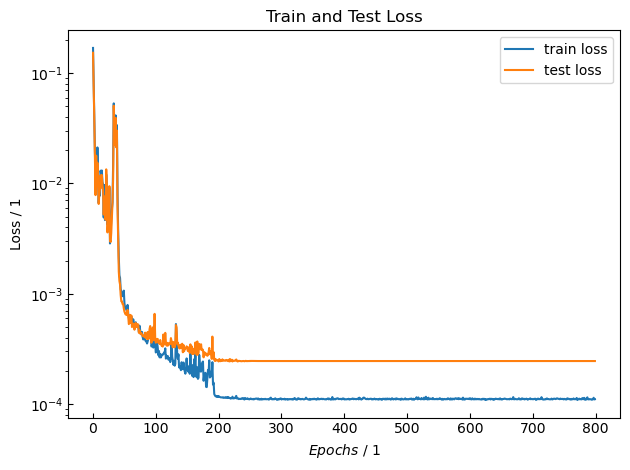

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_006_002.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998972146283075 , R^2(NH3) = 0.9998801176698093
Test Dataset: R^2(H2) = 0.999796544206494 , R^2(NH3) = 0.9997451109283424
Test R^2 gemittelt:  0.9997708275674182
Max Error Training: |x_H2 - x_H2,pred| = 0.012740253679012048 , |x_NH3 - x_NH3,pred| = 0.003967128852064461
Max Error Test: |x_H2 - x_H2,pred| = 0.0071951944647522525 , |x_NH3 - x_NH3,pred| = 0.007459951074451951


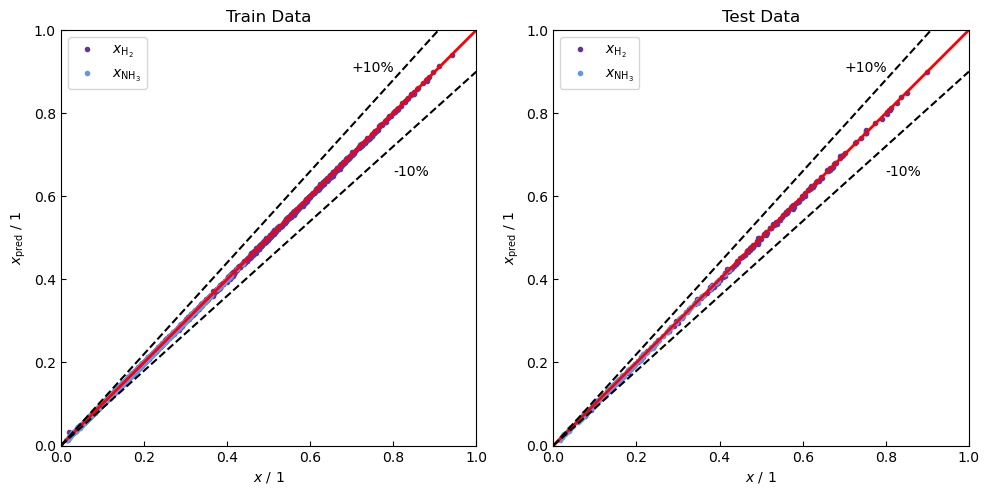

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Test R^2 gemittelt: ', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

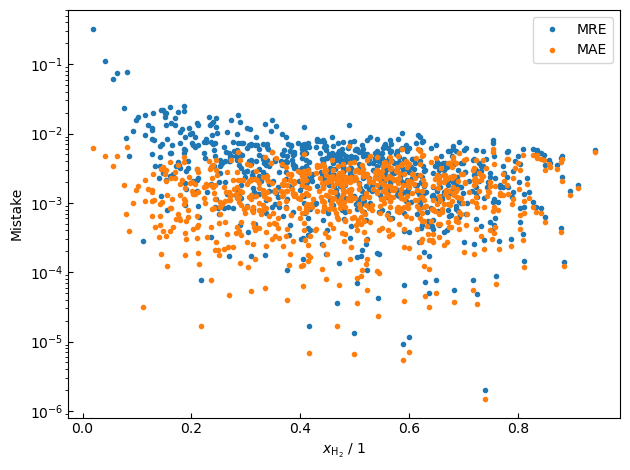

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

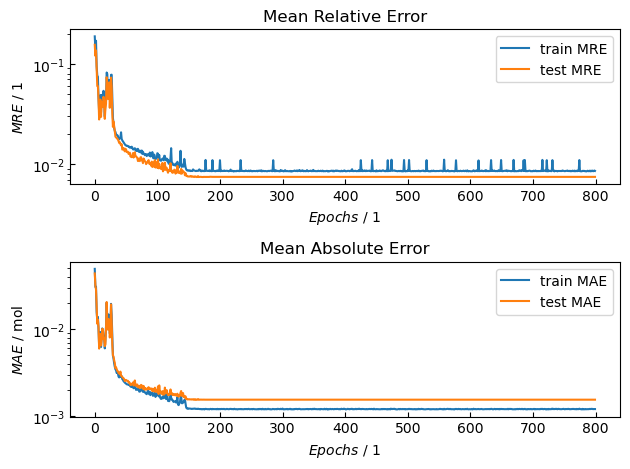

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

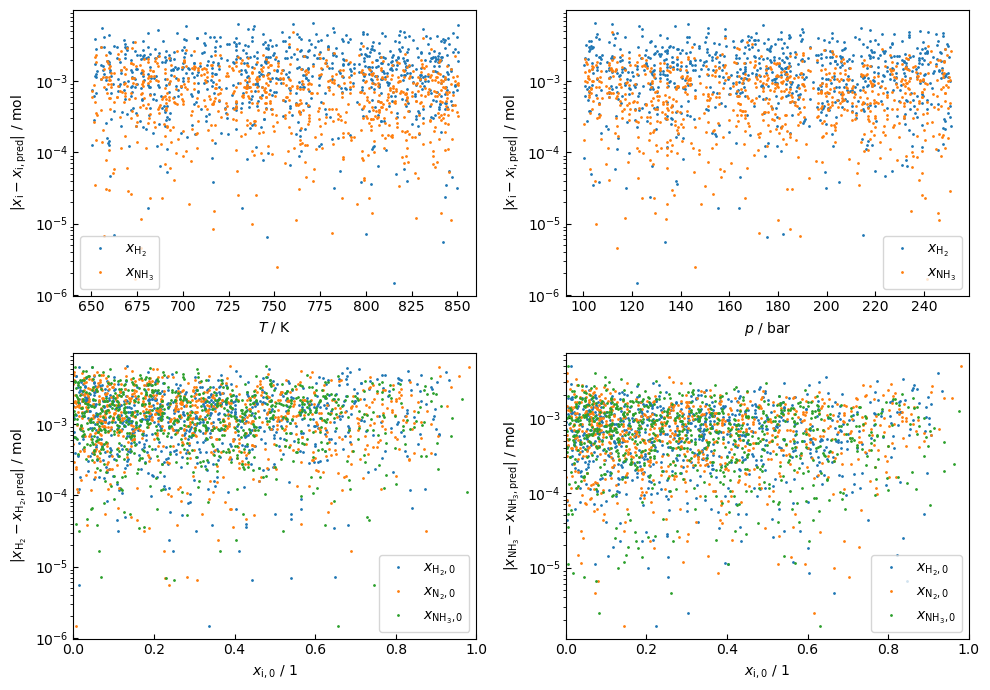

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

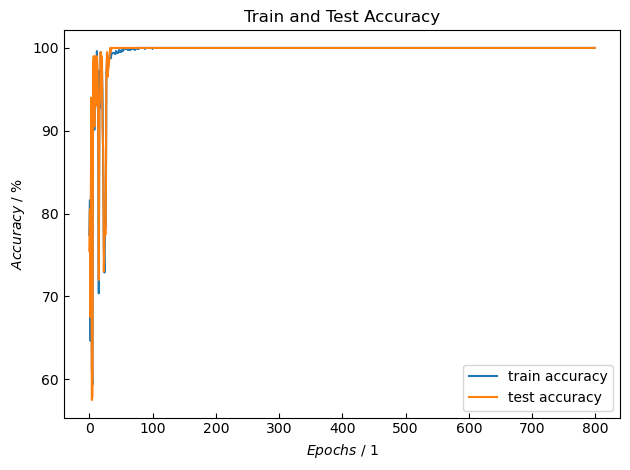

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-9.3820e-01,  1.9071e-01,  4.2470e-01, -6.1213e-01,  2.0885e-01],
        [-8.1606e-01,  2.1853e-01, -2.0454e-01,  4.5452e-01, -2.6382e-01],
        [ 1.3420e+00,  1.0437e+00, -7.5648e-01,  5.5882e-01,  1.7124e-01],
        [ 9.0468e-01, -9.3573e-01, -1.0592e+00,  2.1913e+00, -1.2002e+00],
        [ 4.6592e-01,  1.2939e+00,  5.9378e-01, -3.3471e-01, -2.4063e-01],
        [-1.4235e+00,  5.8443e-01, -2.2827e-01,  4.0609e-01, -1.9104e-01],
        [ 1.2847e-01, -1.3181e+00, -8.6613e-01, -9.3356e-01,  1.8042e+00],
        [-9.2755e-01,  4.7059e-01, -9.4356e-01,  9.3635e-02,  8.3029e-01],
        [ 3.7597e-01,  1.5015e+00, -8.2947e-01,  3.6607e-01,  4.3988e-01],
        [-1.2624e+00, -1.4083e+00, -1.4108e+00,  2.5834e+00, -1.2559e+00],
        [-5.1265e-01,  9.0194e-01,  1.2347e-01, -1.4353e-01,  2.5528e-02],
        [ 8.7705e-01,  2.3089e-01,  4.1486e-01, -1.8945e-01, -2.1351e-01],
        [ 5.5718e-03,  8.5302e-01, -1.1338e+00,  6.8181e-01,  4.1580e-01],
        [ 4.4469e-01, -1.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.0522,  0.1288, -0.3681,  0.1596, -0.3703],
         [ 0.1423, -0.4741, -0.0466, -0.3146, -0.1078],
         [ 0.3291,  0.0899, -0.1558, -0.2154,  0.0566],
         [-0.1951,  0.0598,  0.5525, -0.1679,  0.1189],
         [ 0.2906,  0.4241,  0.4167,  0.2010, -0.2471],
         [-0.4075,  0.1591, -0.2962,  0.2371, -0.2257],
         [ 0.1562,  0.1723,  0.2403, -0.4847, -0.0974],
         [ 0.1806, -0.2887, -0.1710, -0.2535,  0.3360],
         [-0.1162,  0.2851,  0.4805, -0.2950,  0.1994],
         [-0.2904,  0.1160, -0.1582,  0.0698, -0.0575],
         [ 0.4193,  0.4058,  0.1253,  0.0841,  0.3951],
         [ 0.3257, -0.4722, -0.0618,  0.3494,  0.2710],
         [ 0.0501,  0.5477, -0.0022,  0.2979, -0.3145],
         [ 0.3338, -0.1813, -0.4163,  0.1233, -0.1166],
         [ 0.0262, -0.2403,  0.1067,  0.1170, -0.1821],
         [ 0.3072, -0.3309,  0.2723,  0.3848, -0.3106],
         [-0.3823, -0.1978,  0.1301,  0.0973,  0.3248],
         [-0.3296, -0.176

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3040, 0.7616, 0.1470, 0.7281, 0.0952],
        [0.8427, 0.9367, 0.4651, 0.7323, 0.8173]])
tensor([[-0.2296, -0.0926],
        [ 0.3352, -0.2604]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.8547,  0.0868, -1.3352,  0.2575,  1.0471],
        [-0.8378, -1.4711, -1.1141, -0.9800,  2.0950],
        [-0.5446,  0.4824, -0.2008, -0.7768,  0.9910],
        [ 0.5498,  0.7641,  0.0537, -1.3762,  1.3538],
        [-1.4023,  0.0802,  1.9006, -1.0370, -0.8053],
        [ 1.3873, -0.9041, -0.8673, -0.6064,  1.4709],
        [-1.3124, -0.4549, -0.6977,  0.7187, -0.0498],
        [ 1.3609,  0.6387, -0.4384,  0.3809,  0.0409],
        [-0.0896, -0.5045, -0.6923,  0.4943,  0.1742],
        [ 0.7875,  0.8012,  0.8098,  0.0512, -0.8470],
        [ 1.1893, -0.4103, -0.8378,  2.0083, -1.2305],
        [-0.2379,  0.1820, -0.2512,  0.4214, -0.1842],
        [ 1.3987,  0.9757,  0.6939, -0.6409, -0.0259],
        [-0.2482, -1.7039, -0.8631,  1.8846, -1.0791],
        [ 1.3626, -0.2621,  2.2885, -1.2217, -0.9972],
        [-0.1101, -1.0523,  0.8482, -0.5137, -0.3073],
        [-0.8352,  0.1776, -0.1793, -0.5101,  0.6974],
        [ 0.0491, -0.1389,  2.1761, -1.2780, -0.8294],
        [-

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()